In [44]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import emcee
import corner
import os
import scipy.optimize as opt
from plancklens.helpers import mpi
import pickle as pk

In [3]:
import pymaster as nmt

In [5]:
sys.path.append('../..')
from likelihood import cosmology

In [7]:
direct = '/global/u2/l/lonappan/workspace/S4bird/Notebooks/Likelihood/Test'

In [10]:
cosmo = cosmology(direct,2048,10)

In [14]:
tensor = cosmo.get_BB('T',1)

returning cache


In [15]:
scalar = cosmo.get_BB('S',0)

returning cache


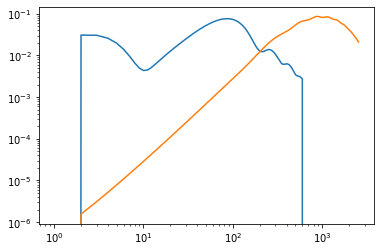

In [16]:
plt.loglog(tensor)
plt.loglog(scalar)

In [142]:
class LH_base:
    
    def __init__(self,lib_dir,nsamples,tensor,lensing,r=0,alens=1,lmin=0,lmax=200,fit_lensed=False):
        self.lib_dir = lib_dir
        self.nsamples = nsamples
        self.fit_lensed = fit_lensed
        self.init = [r,alens]
        print(f"INIT: {self.init}")
        self.tensor = tensor
        self.lensing = lensing
        self.ell = np.arange(len(lensing))
        self.select = np.where((self.ell >= lmin)& (self.ell <= lmax))[0]

        
    def chi_sq(self,theta):
        pass
    
    def initial_opt(self):
        return opt.minimize(self.chi_sq, self.init)
        
    def cl_theory(self,r,Alens):
        th = (r * self.tensor) + (Alens * self.lensing)
        return th
    

    def log_prior(self,theta):
        r,Alens= theta
        if  -0.5 < r < 0.5 and 0 < Alens < 2.:
            return 0.0
        return -np.inf

    def log_probability(self,theta):
        lp = self.log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp  -.5*self.chi_sq(theta)

    def posterior(self):

        res = self.initial_opt()
        pos = np.array(res['x']) + 1e-4 * np.random.randn(100, 2)
        nwalkers, ndim = pos.shape
        sampler = emcee.EnsembleSampler(nwalkers, ndim, self.log_probability)
        sampler.run_mcmc(pos, self.nsamples,progress=True)
        flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
        return flat_samples

    
    def sigma_r(self):
        samples = self.posterior()
        r_samp = np.sort(samples[:,0])
        r_pos = r_samp[r_samp>0]
        return round(r_pos[int(len(r_pos)*.95)], 4)
    
    def plot_posterior(self):
        labels = ["r","Alens"]
        flat_samples = self.posterior()
        plt.figure(figsize=(8,8))
        fig = corner.corner(flat_samples, labels=labels,truths=[0,0])


    
class LH_smith(LH_base):
    
    def __init__(self,lib_dir,data,nsamples,tensor,lensing,r=0,alens=1,lmin=0,lmax=200,fit_lensed=False):
        super().__init__(lib_dir,nsamples,tensor,lensing,r,alens,lmin,lmax,fit_lensed)
        print('Likelihood: Smith')
        self.name = 'smith'
        self.mean = data
    
    def chi_sq(self,theta):
        alpha = 1
        r,Alens = theta
        th = self.cl_theory(r,Alens)
        l = self.ell
        _1 = (2*l) + 1
        _a = (2*l) + alpha
        _f = 9/2
        _2 = ((_1)/(_a))**(1/3.)
        
        first = _1*_f*_2
        second = ((self.mean/th)**(1/3.) -_2)**2
        third = (1-alpha)*np.log(th)
        
        chi = (first*second) + third
        
        return  np.sum(chi[self.select])

In [143]:
lh = LH_smith(direct,scalar+(np.random.rand(len(scalar))*1e-5),2000,tensor,scalar,lmin=10,lmax=2000)

INIT: [0, 1]
Likelihood: Smith


/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in log
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in multiply
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in log
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in multiply
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: di

<Figure size 576x576 with 0 Axes>

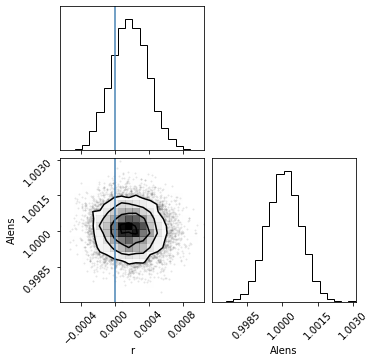

In [144]:
lh.plot_posterior()

In [145]:
lh.sigma_r()

/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in log
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in multiply
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in log
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in multiply
/global/homes/l/lonappan/.conda/envs/PC/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: di

0.0006